本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。将会掌握用 `Keras` 实现循环网络的大部分内容。我们将在**温度预测问题**中介绍这三个概念。在这个问题中，**数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数据来预测最后一个数据点 24 小时之后的温度**。这是一个相当有挑战性的问题，其中包含许多处理时间序列时经常遇到的困难。

我们将会介绍以下三种技巧。
* 循环 dropout（recurrent dropout）。这是一种特殊的内置方法，在循环层中使用 dropout来降低过拟合。
* 堆叠循环层（stacking recurrent layers）。这会提高网络的表示能力（代价是更高的计算负荷）。
* 双向循环层（bidirectional recurrent layer）。将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题。

# 1 温度预测问题

我们将使用一个天气时间序列数据集,生物地球化学研究所的气象站记录。(序列数据)

在这个数据集中，每 `10` 分钟记录 `14` 个不同的量（比如**气温、气压、湿度、风向等**），其中包含多年的记录。原始数据可追溯到 `2003` 年，但本例仅使用 `2009—2016` 年的数据。这个数据集**非常适合用来学习处理数值型时间序列**。我们将会用这个数据集来构建模型，**输入最近的一些数据（几天的数据点），可以预测 24 小时之后的气温**。

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
# 观察耶拿天气数据集的数据
import os

data_dir = r'D:\git\deep-learning-with-python\data\jena_climate_2009_2016'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname,encoding='UTF-8')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
# 将 420551 行数据转换成一个 Numpy 数组

# 解析数据

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
float_data.shape

(420551, 14)

In [5]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

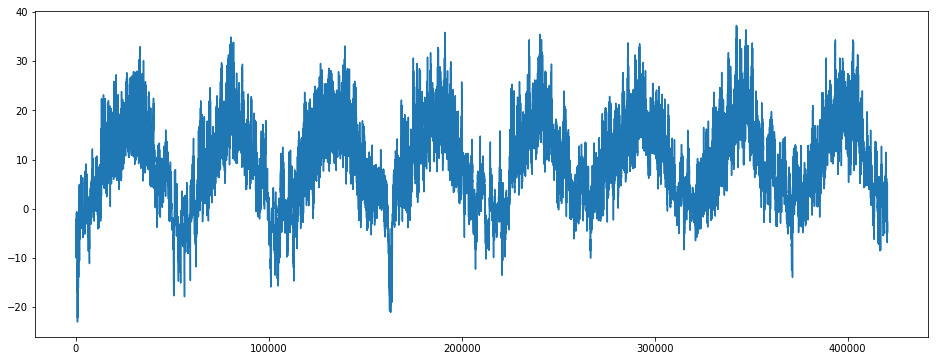

In [6]:
# 绘制温度时间序列

%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(16,6))

temp = float_data[:, 1]  # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

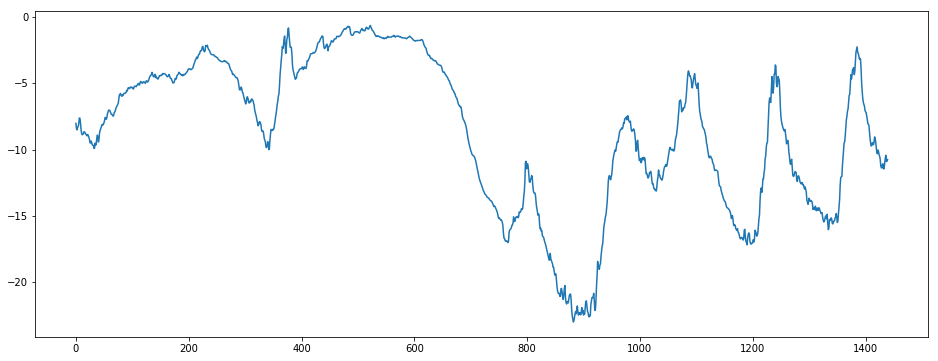

In [7]:
# 绘制前 10 天的温度时间序列:每 10 分钟记录一个数据，所以每天有 144 个数据点(这10 天一定是来自于很冷的冬季月份)
plt.figure(figsize=(16,6))
plt.plot(range(1440), temp[:1440])
plt.show()

# 2 准备数据

这个问题的确切表述如下：一个时间步是 `10` 分钟，每 `steps` 个时间步采样一次数据，给定过去 `lookback` 个时间步之内的数据，能否预测 `delay` 个时间步之后的温度？用到的参数值如下。
* lookback = 720：给定过去 5 天内的观测数据。
* steps = 6：观测数据的采样频率是每小时一个数据点。
* delay = 144：目标是未来 24 小时之后的数据。

数据预处理：

* 将数据预处理为神经网络可以处理的格式。**数据已经是数值型的，所以不需要做向量化**。但数据中的每个时间序列位于不同的范围（比如温度通道位于 -20 到 +30之间，但气压大约在 1000 毫巴上下）。你需要对**每个时间序列分别做标准化，让它们在相似的范围内都取较小的值**。

* **编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度**。因为数据集中的样本是高度冗余的（对于第 `N` 个样本和第 `N+1` 个样本，大部分时间步都是相同的），所以**显式地保存每个样本是一种浪费**。相反，我们将**使用原始数据即时生成样本**。

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前`200000`个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

In [8]:
# 数据标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
# 生成时间序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

上面代码给出了将要用到的生成器。它生成了一个元组 `(samples, targets)`，其中 `samples` 是输入数据的一个批量， `targets` 是对应的目标温度数组。生成器的参数如下。
* data：浮点数数据组成的原始数组，需要进行标准化。
* lookback：输入数据应该包括过去多少个时间步。
* delay：目标应该在未来多少个时间步之后。
* min_index 和 max_index： data 数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试。
* shuffle：是打乱样本，还是按顺序抽取样本。
* batch_size：每个批量的样本数。
* step：数据采样的周期（单位：时间步）。我们将其设为 6，为的是每小时抽取一个数据点。

使用这个抽象的 generator 函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前200 000 个时间步，验证生成器读取随后的 100 000 个时间步，测试生成器读取剩下的时间步。

In [10]:
# 准备训练生成器、验证生成器和测试生成器

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 为了查看整个验证集，需要从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# 为了查看整个测试集，需要从test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 3 一种基于常识的、非机器学习的基准方法

开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别“A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于 90%时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。

本例中，我们可以放心地假设，**温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化**。因此，一种**基于常识的方法就是始终预测 24 小时后的温度等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。**

```python
np.mean(np.abs(preds - targets))
```

In [11]:
# 计算符合常识的基准方法的 MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


得到的 MAE 为 0.29。因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为 0.29×temperature_std 摄氏度，即 2.57℃。

In [12]:
# 将 MAE 转换成摄氏温度误差
celsius_mae = 0.29 * std[1]
celsius_mae
# 这个平均绝对误差还是相当大的。接下来的任务是利用深度学习知识来改进结果。

2.5672247338393395

# 4 一种基本的机器学习方法

在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究复杂且计算代价很高的模型（比如 RNN）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

代码给出了一个全连接模型，首先将数据展平，然后通过两个 Dense 层并运行。注意，最后一个 Dense 层没有使用激活函数，这对于回归问题是很常见的。我们使用 MAE 作为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。

In [14]:
# 训练并评估一个全连接模型

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 25s 49ms/step - loss: 1.1026 - val_loss: 0.5758
Epoch 2/20
500/500 [==============================] - 23s 47ms/step - loss: 0.3748 - val_loss: 0.3236
Epoch 3/20
500/500 [==============================] - 26s 52ms/step - loss: 0.2850 - val_loss: 0.3208
Epoch 4/20
500/500 [==============================] - 27s 53ms/step - loss: 0.2660 - val_loss: 0.3158
Epoch 5/20
500/500 [==============================] - 28s 55ms/step - loss: 0.2517 - val_loss: 0.3325
Epoch 6/20
500/500 [==============================] - 30s 59ms/step - loss: 0.2430 - val_loss: 0.3259
Epoch 7/20
500/500 [==============================] - 29s 57ms/step - loss: 0.2351 - val_loss: 0.3276
Epoch 8/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2296 - val_loss: 0.3592
Epoch 9/20
500/500 [==============================] - 31s 63ms/step - loss: 0.2254 - val_loss: 0.3480
Epoch 10/20
500/500 [==============================] - 28s 55ms/step - loss: 0.220

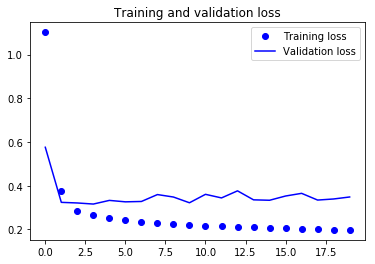

In [15]:
# 验证和训练的损失曲线
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这个基准方法的优点，事实证明，超越这个基准并不容易。**我们的常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。**

**如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？**

* 原因在于，**这个简单的解决方案并不是训练过程所要寻找的目标**。
* 我们在模型空间（即假设空间）中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。
* 这些网络已经相当复杂了。如果你在一个复杂模型的空间中寻找解决方案，那么**可能无法学到简单且性能良好的基准方法，虽然技术上来说它属于假设空间的一部分**。
* 通常来说，这对机器学习是一个非常重要的限制：**如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到简单问题的简单解决方案的。**

# 5 第一个循环网络基准

第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。**前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念**。我们来看一下数据本来的样子：

它是**一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同**。

我们将使用 Chung 等人在 2014 年开发的 `GRU` 层，而不是上一节介绍的 `LSTM` 层。**门控循环单元（GRU， gated recurrent unit）层的工作原理与 LSTM 相同**。但它做了一些简化，因此**运行的计算代价更低（虽然表示能力可能不如 LSTM）。机器学习中到处可以见到这种计算代价与表示能力之间的折中**。

In [15]:
# 训练并评估一个基于 GRU 的模型

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 366s 732ms/step - loss: 0.3145 - val_loss: 0.2702
Epoch 2/20
500/500 [==============================] - 362s 724ms/step - loss: 0.2850 - val_loss: 0.2660
Epoch 3/20
500/500 [==============================] - 370s 741ms/step - loss: 0.2785 - val_loss: 0.2678
Epoch 4/20
500/500 [==============================] - 349s 699ms/step - loss: 0.2742 - val_loss: 0.2620
Epoch 5/20
500/500 [==============================] - 377s 755ms/step - loss: 0.2695 - val_loss: 0.2679
Epoch 6/20
500/500 [==============================] - 348s 697ms/step - loss: 0.2632 - val_loss: 0.2617
Epoch 7/20
500/500 [==============================] - 326s 652ms/step - loss: 0.2579 - val_loss: 0.2640
Epoch 8/20
500/500 [==============================] - 296s 592ms/step - loss: 0.2507 - val_loss: 0.2606
Epoch 9/20
500/500 [==============================] - 659s 1s/step - loss: 0.2477 - val_loss: 0.2698
Epoch 10/20
500/500 [==============================] - 337s 673ms/s

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

图中显示了模型结果。效果好多了！远优于基于常识的基准方法。这证明了机器学习的价值，也证明了循环网络与序列展平的全连接网络相比在这种任务上的优势。

新的验证 MAE 约为 0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为 2.35℃。与最初的误差 2.57℃相比，这个结果确实有所提高，但可能仍有改进的空间。

# 6 使用循环 dropout 来降低过拟合

从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过降低过拟合的一种经典技术——dropout，即将某一层的输入单元随机设为 0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中如何正确地使用dropout，这并不是一个简单的问题。人们早就知道，在循环层前面应用 dropout，这种正则化会妨碍学习过程，而不是有所帮助。 2015 年， 在关于贝叶斯深度学习的博士论文中， Yarin Gal 确定了在循环网络中使用 dropout 的正确方法：对每个时间步应该使用相同的 dropout 掩码（dropoutmask，相同模式的舍弃单元），而不是让 dropout 掩码随着时间步的增加而随机变化。此外，为了对 GRU、 LSTM 等循环层得到的表示做正则化，应该将不随时间变化的 dropout 掩码应用于层的内部循环激活（叫作循环 dropout 掩码）。对每个时间步使用相同的 dropout 掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的 dropout 掩码则会破坏这个误差信号，并且不利于学习过程。

Yarin Gal 使用 Keras 开展这项研究，并帮助将这种机制直接内置到 Keras 循环层中。 Keras的每个循环层都有两个与 dropout 相关的参数：

* **一个是 dropout，它是一个浮点数，指定该层输入单元的 dropout 比率**；
* **另一个是recurrent_dropout，指定循环单元的 dropout 比率**。

我们向 GRU 层中**添加 dropout 和循环 dropout**，看一下这么做对过拟合的影响。因为**使用 dropout正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的 2 倍**。

In [ ]:
# 训练并评估一个使用 dropout 正则化的基于 GRU 的模型
# Using recurrent dropout to fight overfitting

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

结果如图 6-22 所示。成功！前 30 个轮次不再过拟合。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

# 7 循环层堆叠

模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用 dropout）。只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。循环层堆叠（recurrent layerstacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是 7 个大型LSTM 层的堆叠——这个架构很大。在 Keras 中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个 3D 张量），而不是只返回最后一个时间步的输出。这可以通过指定return_sequences=True 来实现。

In [ ]:
# 训练并评估一个使用 dropout 正则化的堆叠 GRU 模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

结果如图所示。可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论。
* 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。但这么做的计算成本很高。
* 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小。

# 8 使用双向RNN

双向 RNN（bidirectional RNN）。双向 RNN 是一种常见的RNN 变体，它在某些任务上的性能比普通 RNN 更好。它常用于自然语言处理，可谓深度学习对自然语言处理的瑞士军刀。

RNN特别依赖于顺序或时间， RNN按顺序处理输入序列的时间步，而打乱时间步或反转时间步会完全改变 RNN 从序列中提取的表示。正是由于这个原因，**如果顺序对问题很重要（比如温度预测问题）， RNN 的表现会很好**。**双向 RNN 利用了 RNN 的顺序敏感性：它包含两个普通 RNN， 比如你已经学过的 GRU 层和 LSTM 层，每个 RNN 分别沿一个方向对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，双向RNN 能够捕捉到可能被单向 RNN 忽略的模式**。

值得注意的是，本节的 **RNN 层都是按时间正序处理序列（更早的时间步在前），这可能一个随意的决定**。至少，至今我们还没有尝试质疑这个决定。**如果 RNN 按时间逆序处理输入序列（更晚的时间步在前），能否表现得足够好呢？**我们在实践中尝试一下这种方法，看一下会发生什么。**你只需要编写一个数据生成器的变体，将输入序列沿着时间维度反转（即将最后一行代码替换为 `yield samples[:, ::-1, :], targets`）**。本节第一个实验用到了一个单 GRU层的网络，我们训练一个与之相同的网络，得到的结果如图所示。

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**逆序 GRU 的效果甚至比基于常识的基准方法还要差很多**，这说明在本例中，**按时间正序处理对成功解决问题很重要**。这非常合理：

**GRU 层通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力（这也是基于常识的基准方法非常强大的原因）**。因此，**按时间正序的模型必然会优于时间逆序的模型**。重要的是，对许多其他问题（包括自然语言）而言，情况并不是这样：**直觉上来看，一个单词对理解句子的重要性通常并不取决于它在句子中的位置**。

我们尝试对 IMDB 示例中的 LSTM 应用相同的技巧。

In [ ]:
# 使用逆序序列训练并评估一个 LSTM

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 作为特征的单词个数
max_features = 10000
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
maxlen = 500

# 加载数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 将序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

模型性能与正序 LSTM 几乎相同。值得注意的是，在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的 RNN 学到的表示不同于在原始序列上学到的表示，正如在现实世界中，如果时间倒流（你的人生是第一天死去、最后一天出生），那么你的心智模型也会完全不同。在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是集成（ensembling）方法背后的直觉，我们将在第 7 章介绍集成的概念。

双向 RNN 正是利用这个想法来提高正序 RNN 的性能。它从两个方向查看数据（见图 6-25），从而得到更加丰富的表示，并捕捉到仅使用正序 RNN 时可能忽略的一些模式。

![image.png](../img/06/双向RNN层的工作原理.png)

在 Keras 中将一个双向 RNN 实例化，我们需要使用 Bidirectional 层，它的第一个参数是一个循环层实例。 Bidirectional 对这个循环层创建了第二个单独实例，然后使用一个实例按正序处理输入序列，另一个实例按逆序处理输入序列。我们在 IMDB 情感分析任务上来试一下这种方法。

In [ ]:
# 训练并评估一个双向 LSTM
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

这个模型的表现比上一节的普通 LSTM 略好，验证精度超过 89%。这个模型似乎也很快就开始过拟合，这并不令人惊讶，因为双向层的参数个数是正序 LSTM 的 2 倍。添加一些正则化，双向方法在这个任务上可能会有很好的表现。

In [ ]:
# 尝试将相同的方法应用于温度预测任务
# 训练一个双向 GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

这个模型的表现与普通 GRU 层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）

# 9 总结

为了提高温度预测问题的性能，你还可以尝试下面这些方法。

* 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的。
* 调节 RMSprop 优化器的学习率。
* 尝试使用 LSTM 层代替 GRU 层。
* 在循环层上面尝试使用更大的密集连接回归器，即更大的 Dense 层或 Dense 层的堆叠。
* 不要忘记最后在测试集上运行性能最佳的模型（即验证 MAE 最小的模型）。否则，你开发的网络架构将会对验证集过拟合。

正如前面所说，深度学习是一门艺术而不是科学。我们可以提供指导，对于给定问题哪些方法可能有用、哪些方法可能没用，但归根结底，每个问题都是独一无二的，你必须根据经验对不同的策略进行评估。目前没有任何理论能够提前准确地告诉你，应该怎么做才能最优地解决问题。你必须不断迭代。

下面是你应该从本节中学到的要点。
* 我们在第 4 章学过，遇到新问题时，最好首先为你选择的指标建立一个基于常识的基准。如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。
* 在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有意义的。有时简单模型就是你的最佳选择。
* 如果时间顺序对数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据展平的模型相比，其性能要更好。
* 想要在循环网络中使用 dropout，你应该使用一个不随时间变化的 dropout 掩码与循环dropout 掩码。这二者都内置于 Keras 的循环层中，所以你只需要使用循环层的 dropout和 recurrent_dropout 参数即可。
* 与单个 RNN 层相比，堆叠 RNN 的表示能力更加强大。但它的计算代价也更高，因此不一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。
* 双向 RNN 从两个方向查看一个序列，它对自然语言处理问题非常有用。但如果在序列数据中最近的数据比序列开头包含更多的信息，那么这种方法的效果就不明显。

**循环注意（recurrent attention）和序列掩码（sequence masking）。这两个概念通常对自然语言处理特别有用**

# 10 市场与机器学习

有些读者肯定想要采用我们这里介绍的方法，并尝试将其应用于预测股票市场上证券的未来价格（或货币汇率等）。市场的统计特征与天气模式等自然现象有很大差别。如果你只能访问公开可用的数据，那么想要用机器学习来打败市场是一项非常困难的任务，你很可能会白白浪费时间和资源，却什么也得不到。

永远要记住，面对市场时，过去的表现并不能很好地预测未来的收益，正如靠观察后视镜是没办法开车的。与此相对的是，如果在数据集中过去能够很好地预测未来，那么机器学习非常适合用于这种数据集。